In [1]:
# from src.representation import *
# from src.syntheticdata.processor import *
# from src.blueprint_pipeline.utils import visualize_multichannel

# fl = FactoryLoader('raw/txt/av')
# f = fl.random_sample()
# spawn = EntityPuncher(f)
# spawn.get_removal_sequences(channels=('assembler', 'inserter', 'belt'))

from src.syntheticdata import load_dataset
from src.machinelearning import SophisticatedCNN


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

def run_cnn_experiment(epochs=15, batch_size=1, learning_rate=0.001):
    """
    Run a full experiment with the SophisticatedCNN model in a Jupyter notebook.
    Includes data generation, training, evaluation, and visualization.
    
    Args:
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
    
    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check if CUDA is available
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Generate synthetic data
    X, y_matrix, y_position, indices = load_dataset()
    
    # Split data into train and test sets
    X_train, X_test, y_matrix_train, y_matrix_test, y_pos_train, y_pos_test, indices_train, indices_test = train_test_split(
        X, y_matrix, y_position, indices, test_size=0.3, random_state=42
    )
    
    # Create data loaders
    train_dataset = MatrixDataset(X_train, indices_train, y_matrix_train, y_pos_train)
    test_dataset = MatrixDataset(X_test, indices_test, y_matrix_test, y_pos_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = SophisticatedCNN().to(device)
    
    # Define loss functions and optimizer
    matrix_criterion = nn.MSELoss()
    position_criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize history dictionary to store metrics
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_matrix_loss': [],
        'train_position_loss': [],
        'test_matrix_loss': [],
        'test_position_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_matrix_loss = 0.0
        train_position_loss = 0.0
        
        for inputs, idx, target_matrix, target_position in train_loader:
            inputs = inputs.to(torch.float32).to(device)
            idx = idx.to(device).long()
            target_matrix = target_matrix.to(torch.float32).to(device)
            target_position = target_position.to(torch.float32).to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            output_matrix, output_position, _ = model(inputs, idx)
            
            # Calculate losses
            m_loss = matrix_criterion(output_matrix, target_matrix)
            p_loss = position_criterion(output_position, target_position)
            loss = m_loss + p_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            train_loss += loss.item() * inputs.size(0)
            train_matrix_loss += m_loss.item() * inputs.size(0)
            train_position_loss += p_loss.item() * inputs.size(0)
        
        # Calculate average training losses
        train_loss = train_loss / len(train_dataset)
        train_matrix_loss = train_matrix_loss / len(train_dataset)
        train_position_loss = train_position_loss / len(train_dataset)
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_matrix_loss = 0.0
        test_position_loss = 0.0
        
        with torch.no_grad():
            for inputs, idx, target_matrix, target_position in test_loader:
                inputs = inputs.to(torch.float32).to(device)
                idx = idx.to(device).long()
                target_matrix = target_matrix.to(torch.float32).to(device)
                target_position = target_position.to(torch.float32).to(device)
                
                # Forward pass
                output_matrix, output_position, _ = model(inputs, idx)
                
                # Calculate losses
                m_loss = matrix_criterion(output_matrix, target_matrix)
                p_loss = position_criterion(output_position, target_position)
                loss = m_loss + p_loss
                
                # Update statistics
                test_loss += loss.item() * inputs.size(0)
                test_matrix_loss += m_loss.item() * inputs.size(0)
                test_position_loss += p_loss.item() * inputs.size(0)
        
        # Calculate average test losses
        test_loss = test_loss / len(test_dataset)
        test_matrix_loss = test_matrix_loss / len(test_dataset)
        test_position_loss = test_position_loss / len(test_dataset)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_matrix_loss'].append(train_matrix_loss)
        history['train_position_loss'].append(train_position_loss)
        history['test_matrix_loss'].append(test_matrix_loss)
        history['test_position_loss'].append(test_position_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f} (Matrix: {train_matrix_loss:.4f}, Position: {train_position_loss:.4f})')
            print(f'  Test Loss: {test_loss:.4f} (Matrix: {test_matrix_loss:.4f}, Position: {test_position_loss:.4f})')
    
    # Visualize results
    visualize_training_history(history)
    visualize_predictions(model, test_loader, device)
    
    return model, history


class MatrixDataset(Dataset):
    """Dataset for matrix data with indices."""
    
    def __init__(self, X, indices, y_matrix, y_position):
        self.X = torch.from_numpy(X)
        self.indices = torch.from_numpy(indices)
        self.y_matrix = torch.tensor(y_matrix)
        self.y_position = torch.tensor(y_position)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.indices[idx], self.y_matrix[idx], self.y_position[idx]

def visualize_training_history(history):
    """
    Visualize training and test losses.
    
    Args:
        history: Dictionary containing training history
    """
    plt.figure(figsize=(16, 6))
    
    # Plot total loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot matrix loss
    plt.subplot(1, 3, 2)
    plt.plot(history['train_matrix_loss'], label='Train Matrix Loss')
    plt.plot(history['test_matrix_loss'], label='Test Matrix Loss')
    plt.title('Matrix Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot position loss
    plt.subplot(1, 3, 3)
    plt.plot(history['train_position_loss'], label='Train Position Loss')
    plt.plot(history['test_position_loss'], label='Test Position Loss')
    plt.title('Position Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_loader, device, num_samples=5):
    """
    Visualize model predictions.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to run model on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get samples from test loader
    inputs, indices, targets, positions = next(iter(test_loader))
    inputs = inputs[:num_samples].to(torch.float32).to(device)
    indices = indices[:num_samples].to(device).long()
    targets = targets[:num_samples].to(torch.float32).to(device)
    positions = positions[:num_samples].to(torch.float32).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs, pred_positions, attention_maps = model(inputs, indices)
    
    # Convert to numpy arrays
    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    outputs = outputs.cpu().numpy()
    positions = positions.cpu().numpy()
    pred_positions = pred_positions.cpu().numpy()
    attention_maps = attention_maps.cpu().numpy()
    
    # Plot results
    plt.figure(figsize=(20, 4 * num_samples))
    
    for i in range(num_samples):
        # Plot input channels
        for c in range(4):
            plt.subplot(num_samples, 7, i * 7 + c + 1)
            plt.imshow(inputs[i, c], cmap='viridis')
            plt.title(f'Input Channel {c+1}')
            plt.colorbar()
            plt.axis('off')
        
        # Plot target matrix
        plt.subplot(num_samples, 7, i * 7 + 5)
        plt.imshow(targets[i, 0], cmap='viridis')
        plt.title(f'Target Matrix\nPos: ({positions[i][0]:.2f}, {positions[i][1]:.2f})')
        plt.colorbar()
        plt.axis('off')
        
        # Plot predicted matrix
        plt.subplot(num_samples, 7, i * 7 + 6)
        plt.imshow(outputs[i, 0], cmap='viridis')
        plt.title(f'Predicted Matrix\nPos: ({pred_positions[i][0]:.2f}, {pred_positions[i][1]:.2f})')
        plt.colorbar()
        plt.axis('off')
        
        # Plot attention map
        plt.subplot(num_samples, 7, i * 7 + 7)
        plt.imshow(attention_maps[i, 0], cmap='hot')
        plt.title('Attention Map')
        plt.colorbar()
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

ImportError: cannot import name 'map_entity_to_key' from 'src.blueprint_pipeline.utils' (f:\Programming\factorio-working-group\src\blueprint_pipeline\utils.py)

Using device: mps


/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:47: DirectionWarning: 'TransportBelt' only has 4-way rotation; defaulting to 0
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:47: DirectionWarning: 'UndergroundBelt' only has 4-way rotation; defaulting to 0
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:47: UnknownKeywordWarning: 'ElectricPole' object has no attribute(s) ['neighbours']; allowed fields are ['name', 'quality', 'position', 'entity_number', 'tags']
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:47: DirectionWarning: 'TransportBelt' only has 4-way rotation; defaulting to 4
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:47: DirectionWarning: 'In

Epoch 5/15:
  Train Loss: 12.3524 (Matrix: 0.0349, Position: 12.3175)
  Test Loss: 12.2647 (Matrix: 0.0347, Position: 12.2301)
Epoch 10/15:
  Train Loss: 11.5964 (Matrix: 0.0345, Position: 11.5619)
  Test Loss: 14.6305 (Matrix: 0.0340, Position: 14.5965)
Epoch 15/15:
  Train Loss: 11.4471 (Matrix: 0.0344, Position: 11.4127)
  Test Loss: 11.4424 (Matrix: 0.0334, Position: 11.4090)


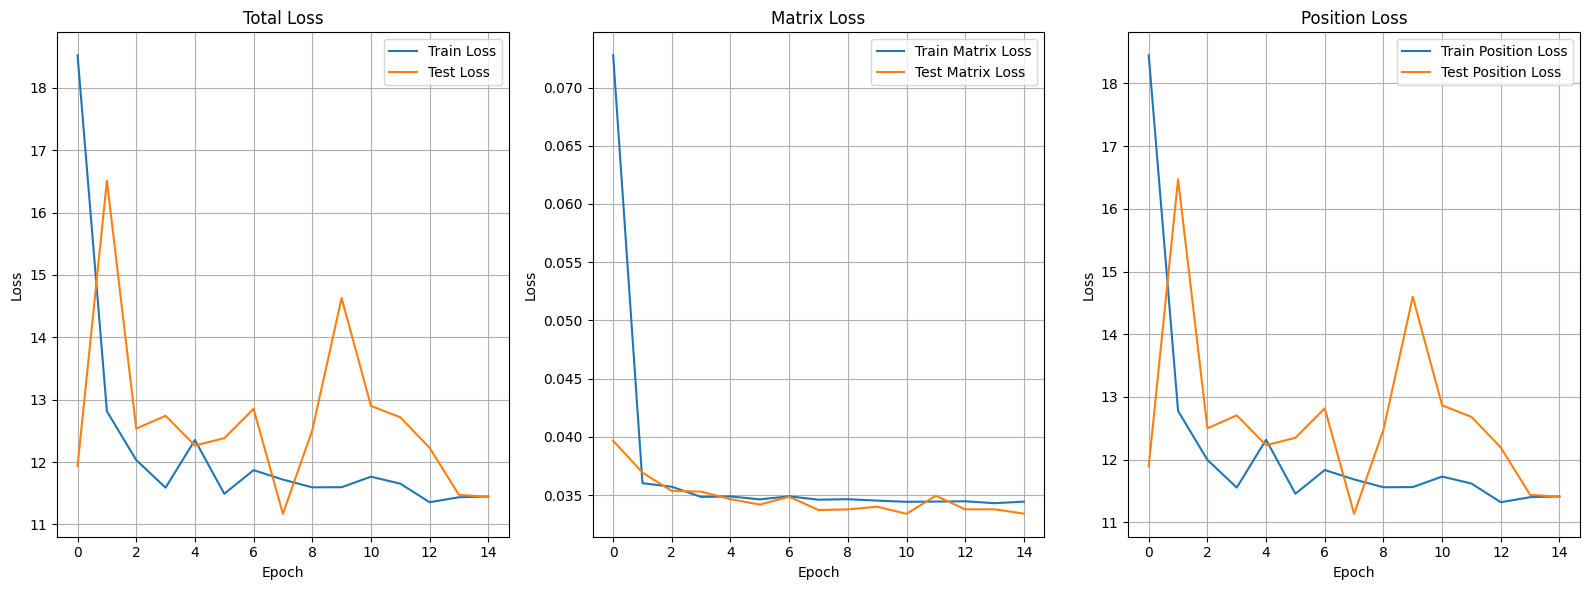

IndexError: index 1 is out of bounds for axis 0 with size 1

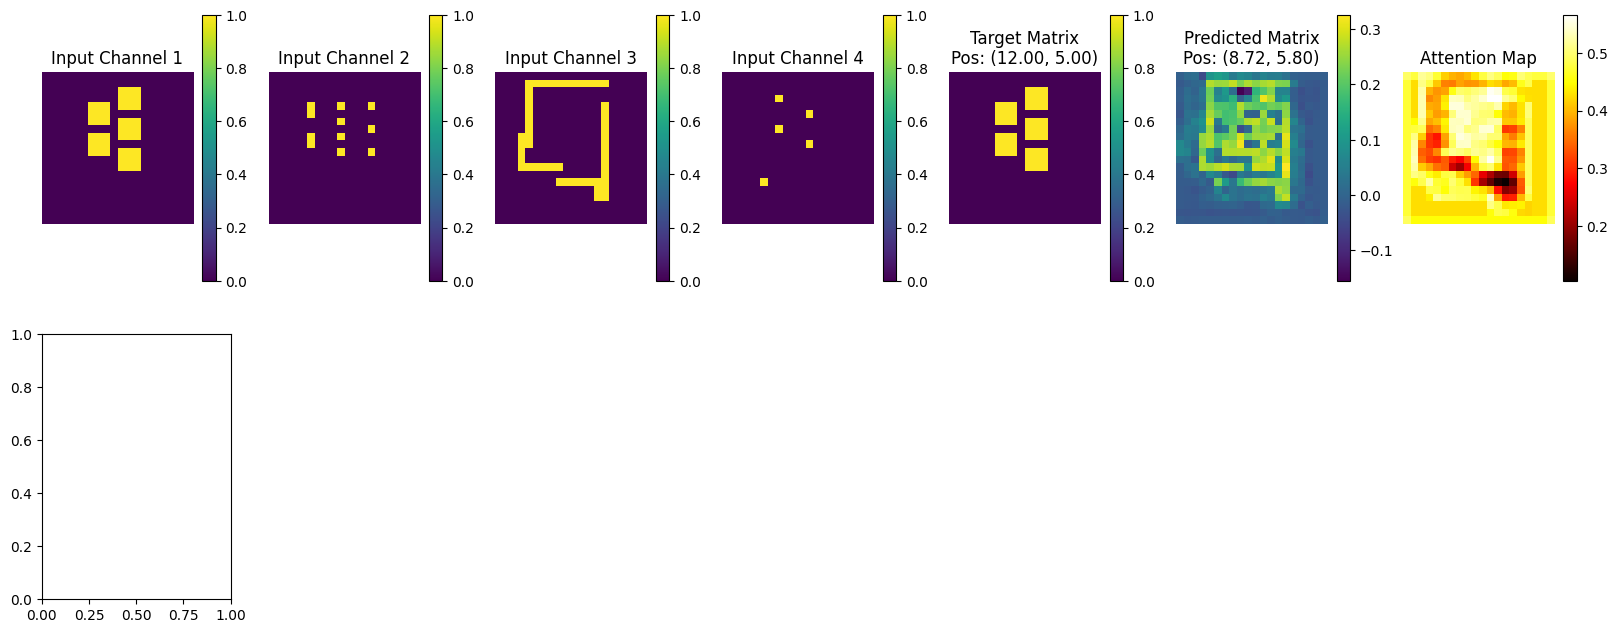

In [3]:
m, h = run_cnn_experiment()

In [4]:
visualize_training_history(h)

NameError: name 'h' is not defined

In [ ]:
# from src.representation import *
# from src.syntheticdata.processor import *
# from src.blueprint_pipeline.utils import visualize_multichannel

# fl = FactoryLoader('raw/txt/av')
# f = fl.random_sample()
# # spawn = EntityPuncher(f)
# # spawn.get_removal_sequences(channels=('assembler', 'inserter', 'belt'))

# ms = blueprint_to_matrices(f)

In [ ]:
from src.syntheticdata.processor import load_dataset

a,b,c,d = load_dataset()
for x in [a,b,c,d]:
    print(len(x))

/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:46: DirectionWarning: 'TransportBelt' only has 4-way rotation; defaulting to 0
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:46: DirectionWarning: 'UndergroundBelt' only has 4-way rotation; defaulting to 0
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:46: UnknownKeywordWarning: 'ElectricPole' object has no attribute(s) ['neighbours']; allowed fields are ['name', 'quality', 'position', 'entity_number', 'tags']
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:46: DirectionWarning: 'TransportBelt' only has 4-way rotation; defaulting to 4
  v = get_blueprintable_from_string(bfile.read())
/Users/david/src/nyu/factorio-working-group/src/syntheticdata/processor.py:46: DirectionWarning: 'In

313
313
313
313
